In [68]:
# Reload external modules if needed (useful during development)
%load_ext autoreload
%autoreload 2

## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
import torchinfo
import sklearn
from dataclasses import dataclass
from typing import Literal, Dict, Any
from utils import show_prediction,fast_gradient_sign_method, save_adversarial_images, get_resnet_blocks, eval_model

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device cpu


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [ ]:
ModelName = Literal["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]

@dataclass
class ModelConfig:
    model_name: ModelName = "resnet50"
    pretrained: bool = True

    def build(self, device: torch.device = device) -> torchvision.models.ResNet:
        """Construct and return the requested torchvision ResNet on the given device."""
        builders: Dict[ModelName, callable] = {
            "resnet18": torchvision.models.resnet18,
            "resnet34": torchvision.models.resnet34,
            "resnet50": torchvision.models.resnet50,
            "resnet101": torchvision.models.resnet101,
            "resnet152": torchvision.models.resnet152,
        }
        # For newer torchvision versions use weights enum; this example uses the simple API
        model = builders[self.model_name](weights='IMAGENET1K_V1' if self.pretrained else None)
        model = model.to(device)
        model.eval()
        return model

AttackName = Literal["fgsm"]

@dataclass
class AttackConfig:
    attack: AttackName = "fgsm"
    epsilon: float = 0.02

@dataclass
class ProbesConfig:
    learning_rate: float
    num_epochs: int

ADV_EXAMPLES_DIR = os.path.join("../adv_examples", ModelConfig.model_name)

NORMAL_ACTIVATIONS_BASE = os.path.join("./normal_activations/", ModelConfig.model_name)
NORMAL_ACTIVATIONS_PATH = os.path.join(NORMAL_ACTIVATIONS_BASE, "activations.pth")

ADV_ACTIVATIONS_BASE = os.path.join("./adv_activations/", ModelConfig.model_name)
ADV_ACTIVATIONS_PATH = os.path.join(ADV_ACTIVATIONS_BASE, "adv_activations.pth")

PROBES_DIR = os.path.join("./probes", AttackConfig.attack, ModelConfig.model_name)

RESULTS_DIR = os.path.join("./results", AttackConfig.attack, ModelConfig.model_name)

#make dirs if they don't exist
os.makedirs(NORMAL_ACTIVATIONS_BASE, exist_ok=True)
os.makedirs(ADV_ACTIVATIONS_BASE, exist_ok=True)
os.makedirs(PROBES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = ModelConfig().build().to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to ../saved_models/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 11.0MB/s]


In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [7]:
# Generate adversarial examples for the entire dataset using FGSM and store them in a list
if not os.path.exists(ADV_EXAMPLES_DIR):
    adv_examples = []
    labels_list = []
    pretrained_model.eval()  # Ensure model is in eval mode

    for imgs, labels in tqdm(data_loader, desc="Generating adversarial examples..."):
        adv_imgs, _ = fast_gradient_sign_method(pretrained_model, imgs, labels, epsilon=0.02)
        adv_examples.extend(adv_imgs.cpu())
        labels_list.extend(labels.cpu())

    # Save adversarial examples
    save_adversarial_images(adv_examples, labels_list, ADV_EXAMPLES_DIR)
    adv_examples_dataset = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

else:
    adv_examples_dataset = torchvision.datasets.ImageFolder(ADV_EXAMPLES_DIR, transform= plain_transforms)

Generating adversarial examples...:   0%|          | 0/157 [00:00<?, ?it/s]

Generating adversarial examples...: 100%|██████████| 157/157 [10:56<00:00,  4.18s/it]


In [ ]:
adv_dataloader = data.DataLoader(adv_examples_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

In [ ]:
# exmp_batch, label_batch = next(iter(data_loader))
# exmp_adv_batch, label = next(iter(adv_dataloader))
# with torch.no_grad():
#     preds_adv = pretrained_model(exmp_adv_batch.to(device))
# # Plot the first 5 original and adversarial images side by side

# fig, axes = plt.subplots(5, 2, figsize=(6, 14))
# for i in range(5):
#     # Original image
#     img = exmp_batch[i].cpu().permute(1, 2, 0).numpy()
#     img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
#     img = np.clip(img, 0, 1)
#     axes[i, 0].imshow(img)
#     axes[i, 0].set_title(f"Original: {label_names[label_batch[i]]}")
#     axes[i, 0].axis('off')
    
#     # Adversarial image (display)
#     adv_img_disp = exmp_adv_batch[i].cpu().permute(1, 2, 0).numpy()
#     adv_img_disp = (adv_img_disp * NORM_STD[None, None]) + NORM_MEAN[None, None]
#     adv_img_disp = np.clip(adv_img_disp, 0, 1)
#     axes[i, 1].imshow(adv_img_disp)

#     # Get model prediction for this adversarial image and use it in the title
#     with torch.no_grad():
#         inp = exmp_adv_batch[i].unsqueeze(0).to(device)  # shape (1,3,224,224)
#         preds = pretrained_model(inp)
#         pred_idx = preds.argmax(dim=-1).item()
#     axes[i, 1].set_title(f"Adversarial: {label_names[pred_idx]}")
#     axes[i, 1].axis('off')

# plt.tight_layout()
# plt.show()

# Hooks to get activations

In [47]:
layers_to_probe = get_resnet_blocks(pretrained_model)

In [50]:
activations = {}

def get_activation(name):
    """Creates a hook function to capture the output of a layer."""
    def hook(model, input, output):
        # Detach from the computation graph and move to CPU
        # Average over spatial dimensions (-1, -2) if output is 4D (batch, channels, H, W)
        if output.dim() == 4:
            activations[name] = output.detach().cpu().mean(dim=(-1, -2))
        else:
            activations[name] = output.detach().cpu()
    return hook


# Register a forward hook for each layer we want to probe
for name, layer in layers_to_probe.items():
    layer.register_forward_hook(get_activation(name))

In [53]:
if not os.path.exists(NORMAL_ACTIVATIONS_PATH):
    # Run inference on a batch of normal images and collect activations
    activations_total = {}
    for exmp_batch, _ in tqdm(data_loader):
        activations = {}
        with torch.no_grad():
            _ = pretrained_model(exmp_batch.to(device))
        for name, module in layers_to_probe.items():
            if name in activations_total:
                activations_total[name] = torch.cat((activations_total[name], activations[name]), dim=0)
            else:
                activations_total[name] = activations[name]
    #save activations_total dictionary
    if len(activations_total) == 5000:
        torch.save(activations_total, NORMAL_ACTIVATIONS_PATH)
        normal_activations = torch.load(NORMAL_ACTIVATIONS_PATH)
else: 
    normal_activations = torch.load(NORMAL_ACTIVATIONS_PATH)

100%|██████████| 157/157 [05:53<00:00,  2.25s/it]


In [58]:
if not os.path.exists(ADV_ACTIVATIONS_PATH):
    adv_activations = {}
    for exmp_batch, _ in tqdm(adv_dataloader):
        activations = {}
        with torch.no_grad():
            _ = pretrained_model(exmp_batch.to(device))
        for name, module in layers_to_probe.items():
            if name in adv_activations:
                adv_activations[name] = torch.cat((adv_activations[name], activations[name]), dim=0)
            else:
                adv_activations[name] = activations[name]
    if len(adv_activations) == 5000:
        torch.save(adv_activations, ADV_ACTIVATIONS_PATH)
        adv_activations = torch.load(ADV_ACTIVATIONS_PATH)
else:
    adv_activations = torch.load(ADV_ACTIVATIONS_PATH)

100%|██████████| 157/157 [05:06<00:00,  1.96s/it]


In [59]:
adv_activations

{'layer1.0': tensor([[0.0187, 0.0703, 0.0742,  ..., 0.0204, 0.4566, 0.0876],
         [0.0783, 0.1612, 0.0720,  ..., 0.1132, 0.5041, 0.1028],
         [0.0407, 0.1132, 0.0391,  ..., 0.0772, 0.3691, 0.1129],
         ...,
         [0.0759, 0.2063, 0.0534,  ..., 0.0820, 0.4158, 0.0964],
         [0.0302, 0.2190, 0.0406,  ..., 0.0134, 0.3692, 0.1208],
         [0.0696, 0.2048, 0.0460,  ..., 0.0726, 0.3763, 0.0888]]),
 'layer1.1': tensor([[0.0228, 0.0756, 0.0406,  ..., 0.0271, 0.4724, 0.0979],
         [0.0822, 0.1664, 0.0683,  ..., 0.1198, 0.5231, 0.1347],
         [0.0449, 0.1186, 0.0283,  ..., 0.0839, 0.3882, 0.0990],
         ...,
         [0.0800, 0.2110, 0.0413,  ..., 0.0887, 0.4487, 0.1290],
         [0.0342, 0.2242, 0.0436,  ..., 0.0200, 0.4104, 0.1690],
         [0.0736, 0.2101, 0.0252,  ..., 0.0792, 0.4063, 0.1221]]),
 'layer1.2': tensor([[0.0245, 0.0808, 0.0971,  ..., 0.0323, 0.4774, 0.0785],
         [0.0839, 0.1717, 0.1077,  ..., 0.1251, 0.5279, 0.1054],
         [0.0464, 0.12

In [60]:
from sklearn.model_selection import train_test_split

# Get the number of samples (assume all layers have the same number of samples)
num_samples = next(iter(normal_activations.values())).shape[0]
indices = np.arange(num_samples)

# Split indices for train/test (same split for all layers)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Create train/test splits for each layer
normal_train = {layer: acts[train_idx] for layer, acts in normal_activations.items()}
normal_test = {layer: acts[test_idx] for layer, acts in normal_activations.items()}
adv_train = {layer: acts[train_idx] for layer, acts in adv_activations.items()}
adv_test = {layer: acts[test_idx] for layer, acts in adv_activations.items()}

In [61]:
from torch.utils.data import TensorDataset

probe_datasets = {}

for layer in normal_activations.keys():
    # Get activations for normal and adversarial samples (train and test splits)
    normal_train_acts = normal_train[layer]
    adv_train_acts = adv_train[layer]
    normal_test_acts = normal_test[layer]
    adv_test_acts = adv_test[layer]

    # Concatenate activations for train and test
    X_train = torch.cat([normal_train_acts, adv_train_acts], dim=0)
    y_train = torch.cat([
        torch.zeros(normal_train_acts.shape[0], dtype=torch.long),
        torch.ones(adv_train_acts.shape[0], dtype=torch.long)
    ], dim=0)

    X_test = torch.cat([normal_test_acts, adv_test_acts], dim=0)
    y_test = torch.cat([
        torch.zeros(normal_test_acts.shape[0], dtype=torch.long),
        torch.ones(adv_test_acts.shape[0], dtype=torch.long)
    ], dim=0)

    # Store as tuple of TensorDatasets for train and test
    probe_datasets[layer] = {
        'train': TensorDataset(X_train, y_train),
        'test': TensorDataset(X_test, y_test)
    }

In [62]:
# Define linear probes for each layer with the corresponding input sizes
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.linear(x)

probe_input_dims = {layer: acts.shape[1] for layer, acts in normal_activations.items()}

linear_probes = {
    layer: LinearProbe(input_dim)
    for layer, input_dim in probe_input_dims.items()
}

In [63]:
# Train a linear probe for each layer and store results
probe_results = {}

num_epochs = 20
for layer, probe in linear_probes.items():
    print(f"\nTraining probe for {layer}...")
    probe = probe.to(device)
    optimizer = optim.Adam(probe.parameters(), lr=1e-2)
    criterion = nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(probe_datasets[layer]['train'], batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(probe_datasets[layer]['test'], batch_size=128, shuffle=False)

    # Training loop
    i = 0
    for epoch in range(num_epochs):
        probe.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = probe(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = total_loss / total
        acc = correct / total
        i += 1
        if i % 5 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

    # Evaluate on test set
    probe.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = probe(X_batch)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_acc = correct / total
    print(f"Test accuracy for {layer}: {test_acc:.4f}")
    probe_results[layer] = test_acc
    # Save the trained probe for this layer
    torch.save(probe.state_dict(), os.path.join(PROBES_DIR, f"{layer}.pth"))


Training probe for layer1.0...
  Epoch 5/20 - Loss: 0.6026 - Accuracy: 0.7000
  Epoch 10/20 - Loss: 0.5335 - Accuracy: 0.7600
  Epoch 15/20 - Loss: 0.4977 - Accuracy: 0.7600
  Epoch 20/20 - Loss: 0.4765 - Accuracy: 0.7400
Test accuracy for layer1.0: 0.7143

Training probe for layer1.1...
  Epoch 5/20 - Loss: 0.5892 - Accuracy: 0.8000
  Epoch 10/20 - Loss: 0.5172 - Accuracy: 0.8000
  Epoch 15/20 - Loss: 0.4780 - Accuracy: 0.7800
  Epoch 20/20 - Loss: 0.4539 - Accuracy: 0.7800
Test accuracy for layer1.1: 0.7143

Training probe for layer1.2...
  Epoch 5/20 - Loss: 0.6217 - Accuracy: 0.5800
  Epoch 10/20 - Loss: 0.5518 - Accuracy: 0.8000
  Epoch 15/20 - Loss: 0.5099 - Accuracy: 0.8000
  Epoch 20/20 - Loss: 0.4838 - Accuracy: 0.8000
Test accuracy for layer1.2: 0.7143

Training probe for layer2.0...
  Epoch 5/20 - Loss: 0.4952 - Accuracy: 0.8200
  Epoch 10/20 - Loss: 0.4373 - Accuracy: 0.8200
  Epoch 15/20 - Loss: 0.4165 - Accuracy: 0.7800
  Epoch 20/20 - Loss: 0.3985 - Accuracy: 0.8000
Tes

In [64]:
# save results as json file

with open(os.path.join(RESULTS_DIR, "probes_accuracy.json"), "w") as f:
    json.dump(probe_results, f)

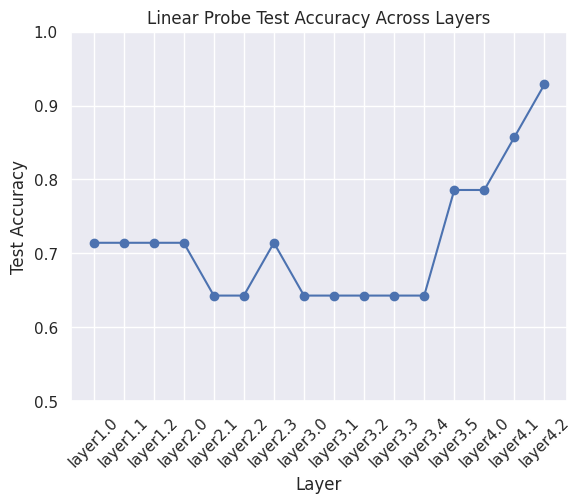

In [65]:
# Plot probe test accuracy across layers
layer_names = list(probe_results.keys())
accuracies = [probe_results[layer] for layer in layer_names]

plt.figure()
plt.plot(layer_names, accuracies, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('Layer')
plt.title('Linear Probe Test Accuracy Across Layers')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.show()

In [69]:
_ = eval_model(data_loader, pretrained_model)

Validating...: 100%|██████████| 157/157 [05:36<00:00,  2.14s/it]

Top-1 error: 16.84%
Top-5 error: 3.58%


In [70]:
_ = eval_model(adv_dataloader, pretrained_model)

Validating...: 100%|██████████| 157/157 [06:00<00:00,  2.30s/it]

Top-1 error: 99.52%
Top-5 error: 98.32%
